# San Francisco Crime
### Considerations
TODO

### Imports

In [1]:
import pandas as pd
import matplotlib
import seaborn
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set()

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import xgboost as xgb

pd.options.mode.chained_assignment = None  # default='warn'

### Map
Before we dive into the data, we look at the map of San Francisco

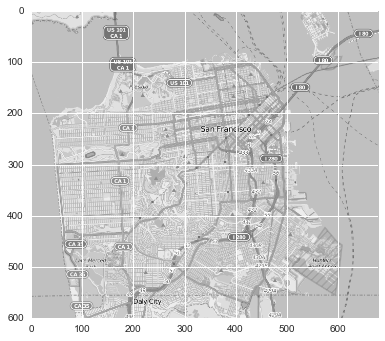

In [2]:
mapdata = np.loadtxt("../data/sf_map_copyright_openstreetmap_contributors.txt")
plt.imshow(mapdata, cmap = plt.get_cmap('gray'))

## Data
### Import Data

In [3]:
data_train = pd.read_csv('../data/train.csv', sep = ',')

### Rough Data Analysis
We see that there are 878049 observations and no missing values.

In [4]:
data_train.describe(percentiles=[]).transpose()

count        mean       std         min         50%    max
X  878049.0 -122.422616  0.030354 -122.513642 -122.416420 -120.5
Y  878049.0   37.771020  0.456893   37.707879   37.775421   90.0

TODO

In [5]:
data_train.describe(percentiles=[], include=['O']).transpose()

count  unique                           top    freq
Dates       878049  389257           2011-01-01 00:01:00     185
Category    878049      39                 LARCENY/THEFT  174900
Descript    878049     879  GRAND THEFT FROM LOCKED AUTO   60022
DayOfWeek   878049       7                        Friday  133734
PdDistrict  878049      10                      SOUTHERN  157182
Resolution  878049      17                          NONE  526790
Address     878049   23228        800 Block of BRYANT ST   26533

### Target Variable
TODO

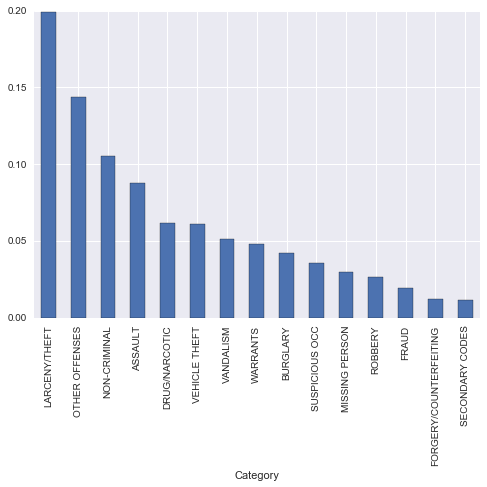

In [6]:
d = data_train.groupby('Category').size().sort_values(ascending=False)
dPercent = d / d.sum()
dPercent[:15].plot(kind='bar')

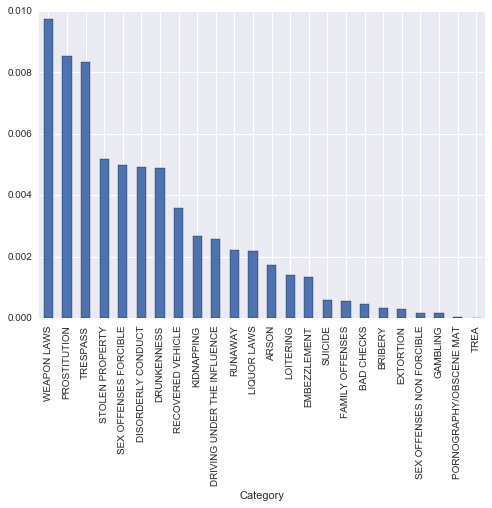

In [7]:
dPercent[15:].plot(kind="bar")

As the top 15 crimes (from 39) contain 93,32% of all crimes, we cut the categories

In [8]:
dPercent[:15].sum()

0.93318710003655825

### Test Data
The training data and test data rotate every week. Besides the target variable "Category" also "Descript" and "Resolution" are missing from the the test set.

In [9]:
data_test = pd.read_csv('../data/test.csv', sep = ',')

### Data Anmalies
#### LongLat
First convert all X/Y Values to numeric to be able to compare them.

In [10]:
d_train_x = pd.to_numeric(data_train['X'])
d_train_y = pd.to_numeric(data_train['Y'])
d_test_x = pd.to_numeric(data_test['X'])
d_test_y = pd.to_numeric(data_test['Y'])

In [11]:
data_train["X"][(d_train_x < -122.52469) | (d_train_x > -122.33663)].unique()

array([-120.5])

In [12]:
data_train["Y"][(d_train_y < 37.69862) | (d_train_y > 37.82986)].unique()

array([ 90.])

In [13]:
data_test["X"][(d_test_x < -122.52469) | (d_test_x > -122.33663)].unique()

array([-120.5])

In [14]:
data_test["Y"][(d_test_y < 37.69862) | (d_test_y > 37.82986)].unique()

array([ 90.])

### Standart Features

#### Dates
TODO

In [15]:
def feature_dates(data):
    data['Dates'] = pd.to_datetime(data['Dates'], format='%Y-%m-%d %H:%M:%S') #split up in date and time?
    return np.asarray(data['Dates']), ['Dates']

#### DayOfWeek
TODO

In [16]:
def feature_day_of_week(data):
    return pd.get_dummies(data['DayOfWeek']), data['DayOfWeek'].unique().tolist()

#### PdDistrict
TODO

In [17]:
data_train['PdDistrict'].unique()

array(['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL',
       'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN'], dtype=object)

In [18]:
def feature_pd_district(data):
    return pd.get_dummies(data['PdDistrict']), data_train['PdDistrict'].unique().tolist()

#### Address
TODO

In [19]:
def feature_address(data):
    return np.asarray(data['Address'])
#unnötig da wir LatLong haben?

#### X (Longitude)
TODO

In [20]:
def feature_longitude(data):
    return (data.X-data.X.mean())/data.X.std(), ['Longitude(X)']


#### Y (Latitude)
TODO

In [21]:
def feature_latitude(data):
    return (data.Y-data.Y.mean())/data.Y.std(), ['Latitude(Y)']

### Derived Features
weitere?
- Season?
- frequency of category?
- isWeekend?
- crime by day / district / year?

#### Time-based

In [22]:
def feature_year(data):
    df = data
    df['year'] = pd.to_datetime(data['Dates']).dt.year
    years = np.asarray(pd.get_dummies(df['year']))
    yearsNames = df['year'].unique().tolist()
    return years, yearsNames 

In [23]:
def month(data):
    df = data
    df['month'] = pd.to_datetime(data['Dates']).dt.month
    months = np.asarray(pd.get_dummies(df['month']))
    return months

In [24]:
def feature_daytime(data):
    df = data
    df['hour'] = pd.to_datetime(data['Dates']).dt.hour
    daytimes = ['night', 'morning', 'noon', 'afternoon', 'evening']
    res = pd.cut(df['hour'], [-1,6,11,15,18,22,25], labels=['night', 'morning', 'noon', 'afternoon', 'evening', 'night2']).copy()
    res[res == 'night2'] = 'night'
    res = res.cat.remove_unused_categories()
    res = pd.get_dummies(res)
    return np.asarray(res), daytimes

In [25]:
def feature_seasons(data):
    df = data
    df['month'] = pd.to_datetime(data['Dates']).dt.month
    seasons = ['winter', 'spring', 'summer', 'fall']
    res = pd.cut(df['month'], [0,2,3,8,11,12], labels=['winter', 'spring', 'summer', 'fall', 'winter2'])
    res[res == 'winter2'] = 'winter'
    res = res.cat.remove_unused_categories()
    res = pd.get_dummies(res)
    return np.asarray(res), seasons

#### Address-based

In [26]:
def feature_street_corner(data):
    d = np.asarray(data['Address'].apply(lambda x: 1 if '/' in x else 0))  
    return d, ["Street Corner"]

#### Location-based

In [27]:
def regions(data):
    #preprocessing should kill the outlier
    df = data
    cutX = pd.qcut(data.X, 5, labels=[1,2,3,4,5])
    cutY = pd.qcut(data.Y, 5, labels=[1,2,3,4,5])
    df['cutX'] = cutX
    df['cutY'] = cutY
    sumF = df['cutX'] * 6 + df['cutY']
    features = pd.get_dummies(sumF)
    return np.asarray(features)

In [28]:
def feature_crimeProbPerReg_train(data):
    return feature_crimeProbPerReg(data)

def feature_crimeProbPerReg_test(data):
    return feature_crimeProbPerReg(data, test=True)

def feature_crimeProbPerReg(data, test=False):
    df = data
    df['cutX'] = pd.qcut(df.X, 10, labels=[1,2,3,4,5,6,7,8,9,10])
    df['cutY'] = pd.qcut(df.Y, 10, labels=[1,2,3,4,5,6,7,8,9,10])
    df['sumF'] = df['cutX'] * 11 + df['cutY']
    
    if not test:
        crimeProReg = df.groupby(['sumF', 'Category']).size().unstack('sumF')
        crimeProReg = crimeProReg/crimeProReg.sum()
        crimeProReg = crimeProReg.fillna(0)
        crimeProReg = crimeProReg.transpose()
        crimeProReg = crimeProReg.reset_index('sumF')
        pickle.dump(crimeProReg, open("crimeProbPerReg.p", "wb" ))  #save table with crime rates pro crime and region
    else:
        crimeProReg = pickle.load(open("crimeProbPerReg.p", "rb"))
    
    mergedR = df.merge(crimeProReg, on='sumF')#.fillna(0)
    res = mergedR.iloc[:, len(df.columns):len(mergedR.columns)]
    res = (res-res.mean())/res.std()
    return np.asanyarray(res), res.columns.tolist()

### Left out Features
TODO

#### Descript
TODO

In [29]:
#def feature_descript(data):


#### Resolution
The orderDate as is doesn't help with the classification task, but derived features might.

In [30]:
#def feature_resolution(data):


### Generate Feature Set

In [66]:
def getY(data):
    numCat = len(data['Category'].unique()) 
    d = data['Category']
    d = d.astype('category')
    d = d.cat.rename_categories(np.arange(numCat))
    return np.asarray(d)
    #return pd.get_dummies(data['Category'])

def getX(data, test_set=False):
    
    feature_methodes = [  feature_pd_district, feature_daytime,\
                          feature_day_of_week, feature_seasons, feature_street_corner,\
                          feature_year, feature_latitude, feature_longitude]

#    if(test_set == False):
#        feature_methodes += [feature_crimeProbPerReg_train]
#    else:
#        feature_methodes += [feature_crimeProbPerReg_test]
    
    feats = []
    names = []

    for func in feature_methodes:
        print(func)
        f, n = func(data)
        if f.ndim == 1:
            f = f.reshape([f.shape[0],1])
        print(f.shape)    
        feats.append(f)
        names.extend(n)
        
#    f, n = hakans_featuer(alles was du willst)    
#    feats.append(f)
#    names.extend(n)

    data_set = np.concatenate([f for f in feats], axis=1).astype(float)
    return data_set, names #sum(names,[]) ???

In [67]:
print("get train and test features")

train_data, test_data = train_test_split(data_train, test_size=0.3)

train_x, names = getX(train_data)
train_y = getY(train_data)

test_x, names = getX(test_data, test_set=True)
test_y = getY(test_data)

get train and test features
<function feature_pd_district at 0x7f04ea8c30d0>
(614634, 10)
<function feature_daytime at 0x7f04ea8c3ea0>
(614634, 5)
<function feature_day_of_week at 0x7f04ea86d510>
(614634, 7)
<function feature_seasons at 0x7f04ea98bd08>
(614634, 4)
<function feature_street_corner at 0x7f04ea86d8c8>
(614634, 1)
<function feature_year at 0x7f04ea851488>
(614634, 13)
<function feature_latitude at 0x7f04ea9039d8>
(614634, 1)
<function feature_longitude at 0x7f04ea86dd08>
(614634, 1)
<function feature_pd_district at 0x7f04ea8c30d0>
(263415, 10)
<function feature_daytime at 0x7f04ea8c3ea0>
(263415, 5)
<function feature_day_of_week at 0x7f04ea86d510>
(263415, 7)
<function feature_seasons at 0x7f04ea98bd08>
(263415, 4)
<function feature_street_corner at 0x7f04ea86d8c8>
(263415, 1)
<function feature_year at 0x7f04ea851488>
(263415, 13)
<function feature_latitude at 0x7f04ea9039d8>
(263415, 1)
<function feature_longitude at 0x7f04ea86dd08>
(263415, 1)


## xgBoost

In [68]:
print(train_x.shape)
print(train_y.shape)

(614634, 42)
(614634,)


In [69]:
xg_train = xgb.DMatrix( train_x, label=train_y)
xg_test = xgb.DMatrix(test_x, label=test_y)

In [84]:
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 20
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 39
param['eval_metric'] = 'mlogloss'
watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
num_round = 10

In [85]:
bst = xgb.train(param, xg_train, num_round, watchlist );

[0]	train-mlogloss:3.359952	test-mlogloss:3.453089
[1]	train-mlogloss:3.164813	test-mlogloss:3.322347
[2]	train-mlogloss:3.008353	test-mlogloss:3.223512
[3]	train-mlogloss:2.877313	test-mlogloss:3.142032
[4]	train-mlogloss:2.763505	test-mlogloss:3.074052
[5]	train-mlogloss:2.663526	test-mlogloss:3.016043
[6]	train-mlogloss:2.574520	test-mlogloss:2.965513
[7]	train-mlogloss:2.492610	test-mlogloss:2.920830
[8]	train-mlogloss:2.418501	test-mlogloss:2.881112
[9]	train-mlogloss:2.351064	test-mlogloss:2.845542


In [81]:
pred = bst.predict( xg_test );

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)


In [75]:
pred[0]


array([ 0.02009301,  0.03984019,  0.01974858,  0.0197736 ,  0.03902803,
        0.02065921,  0.02015132,  0.02278783,  0.02127514,  0.01985242,
        0.01979477,  0.01980017,  0.02135208,  0.02226672,  0.01976285,
        0.02016259,  0.09487423,  0.02005419,  0.0198314 ,  0.0244087 ,
        0.04392842,  0.03751923,  0.0197313 ,  0.02075874,  0.02054398,
        0.02373842,  0.01979264,  0.02219032,  0.02098149,  0.01976249,
        0.02105387,  0.01987298,  0.02892996,  0.01972843,  0.02197768,
        0.03718674,  0.030264  ,  0.02601263,  0.02050962], dtype=float32)

In [82]:
print ('predicting, classification error=%f' % (sum( int(pred[i]) != test_y[i] for i in range(len(test_y))) / float(len(test_y)) ))


TypeError: only length-1 arrays can be converted to Python scalars

In [87]:
testd_y = pd.get_dummies(test_data['Category'])
log_loss(testd_y, pred)

2.8265092718158402

In [88]:
data_train = pd.read_csv('../data/train.csv', sep = ',')
data_test = pd.read_csv('../data/test.csv', sep = ',')

train_x, names = getX(train_data)
train_y = getY(train_data)
test_x, names = getX(test_data, test_set=True)

xg_train = xgb.DMatrix( train_x, label=train_y)
xg_test = xgb.DMatrix(test_x)

bst = xgb.train(param, xg_train, num_round, watchlist )
pred = bst.predict( xg_test )

output = pd.DataFrame(pred, index=data_test.index, ) #columns=model.classes_)
output.to_csv("results.csv", index_label="Id")

<function feature_pd_district at 0x7f04ea8c30d0>
(614634, 10)
<function feature_daytime at 0x7f04ea8c3ea0>
(614634, 5)
<function feature_day_of_week at 0x7f04ea86d510>
(614634, 7)
<function feature_seasons at 0x7f04ea98bd08>
(614634, 4)
<function feature_street_corner at 0x7f04ea86d8c8>
(614634, 1)
<function feature_year at 0x7f04ea851488>
(614634, 13)
<function feature_latitude at 0x7f04ea9039d8>
(614634, 1)
<function feature_longitude at 0x7f04ea86dd08>
(614634, 1)
<function feature_pd_district at 0x7f04ea8c30d0>
(263415, 10)
<function feature_daytime at 0x7f04ea8c3ea0>
(263415, 5)
<function feature_day_of_week at 0x7f04ea86d510>
(263415, 7)
<function feature_seasons at 0x7f04ea98bd08>
(263415, 4)
<function feature_street_corner at 0x7f04ea86d8c8>
(263415, 1)
<function feature_year at 0x7f04ea851488>
(263415, 13)
<function feature_latitude at 0x7f04ea9039d8>
(263415, 1)
<function feature_longitude at 0x7f04ea86dd08>
(263415, 1)


[0]	train-mlogloss:3.359952	test-mlogloss:3.453089
[1]	train-mlogloss:3.164813	test-mlogloss:3.322347
[2]	train-mlogloss:3.008353	test-mlogloss:3.223512
[3]	train-mlogloss:2.877313	test-mlogloss:3.142032
[4]	train-mlogloss:2.763505	test-mlogloss:3.074052
[5]	train-mlogloss:2.663526	test-mlogloss:3.016043
[6]	train-mlogloss:2.574520	test-mlogloss:2.965513
[7]	train-mlogloss:2.492610	test-mlogloss:2.920830
[8]	train-mlogloss:2.418501	test-mlogloss:2.881112
[9]	train-mlogloss:2.351064	test-mlogloss:2.845542
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  preds = preds.reshape(nrow, preds.size / nrow)


NameError: name 'model' is not defined